<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Session6_Regularization/EVA4_S6_LossLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

---
Convolution layer was being used as the last layer. Use GAP to reduce the last big layer. Since model's capacity is reduced, add another convolution block after GAP to increase capacity.

Results:

---
1. Number of parameters: 9.5K
2. Training accuracy : 98.92%
3. Testing accuracy : 99.15%

Analysis:

---



1. Test accuracy is still not achieving desired value. Model is not showing any overfitting. Shows model is trained harder. 

Further Understanding

1. With decrease of the dropout from 0.25 to 0.01, test accuracy increased.
2. Number of channels in the first layer increased from 8 to 16 brought increase in test accuracy.

---



Importing Libraries

In [0]:
#A future statement is a directive to the compiler that a particular module should be compiled using syntax or semantics that will be available in a specified future release of Python.
from __future__ import print_function

# torch is the main module that holds all the things you need for Tensor computation.
import torch

# nn module provides many classes and functions to build neural networks.
# models, all kinds of layers, activation functions, parameter classes, etc
import torch.nn as nn

# functional api such as relu
import torch.nn.functional as F

# it offers all the optimizers like SGD, ADAM
import torch.optim as optim

#Torchvision is a package in the PyTorch library containing computer-vision models, datasets, and image transformations
from torchvision import datasets, transforms

#Matplotlib for graphs.
import matplotlib.pyplot as plt

Data Transformations

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    #dtype = torch.cuda.FloatTensor

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


The model

In [0]:
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Convolution layer-1  
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)                        
        ) #Output size- 28. RF=3

        #Convolution layer-2  
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)                        
        ) #Output size- 28. RF=5

        # Maxpooling
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14 RF = 6
        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 14 RF = 6

        #Convolution layer-3  
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)                        
        ) #Output size- 12. RF=10

        #Convolution layer-4  
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)                        
        ) #Output size- 10. RF=14

        #Convolution layer-5  
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)                        
        ) #Output size- 8. RF=18

        #Convolution layer-6  
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)                        
        ) #Output size- 6. RF=22

        #Convolution layer-7  
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)                        
        ) #Output size- 4. RF=26

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1  RF = 32

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        

        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)

        
                      
        # Flatten layer
        x = x.view(-1, 10)
        return F.log_softmax(x)

Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,304
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             128
            Conv2d-9            [-1, 8, 12, 12]             576
             ReLU-10            [-1, 8, 12, 12]               0
      BatchNorm2d-11            [-1, 8, 12, 12]              16
           Conv2d-12            [-1, 8, 10, 10]             576
             ReLU-13            [-1, 8, 10, 10]               0
      BatchNorm2d-14            [-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

#To capture list of data, label, prediction which were predicted wrong.

label_wrong = torch.Tensor().to(device)
label_wrong = label_wrong.long()
pred_wrong = torch.Tensor().to(device)
pred_wrong = pred_wrong.long()
image_wrong = torch.Tensor().to(device)



def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    #print("Shape\n",data.shape)
    #print("Shape\n",target.shape)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    
    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # L1 Loss Calculation
    l1_reg_loss = 0
    if is_L1_loss:
      #print("L1 Regularization is being calculated")      
      l1_crit = nn.L1Loss(size_average=False)
      
      for param in model.parameters():
        zero_target = torch.zeros_like(param, requires_grad=True)
        l1_reg_loss += l1_crit(param, zero_target)

        factor = 0.0005
        l1_reg_loss *= factor

    loss += l1_reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #print("Actual label:\n",target[:5])
    #print("Predicted output:\n", pred[:5])

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    label_wrong_delta = torch.Tensor().to(device)
    label_wrong_delta = label_wrong.long()
    pred_wrong_delta = torch.Tensor().to(device)
    pred_wrong_delta = pred_wrong.long()
    image_wrong_delta = torch.Tensor().to(device)
    

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            #print("Actual label:\n",target.shape)
            #print("Predicted output:\n", pred.shape)
            #print("Shape of data:\n",data.shape)
            
            #To check if the predicted output is equal to the label.
            index_wrong = ~pred.eq(target.view_as(pred))
            
            label_wrong_delta = torch.cat((label_wrong_delta, target.view_as(pred)[index_wrong]), dim=0)
            pred_wrong_delta = torch.cat((pred_wrong_delta, pred[index_wrong]), dim=0)
            image_wrong_delta = torch.cat((image_wrong_delta, data[index_wrong]), dim=0)            
            

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    #print("Size of delta of wrong labels:", label_wrong_delta.shape)
    return label_wrong_delta, pred_wrong_delta, image_wrong_delta

In [8]:
from torch.optim.lr_scheduler import StepLR

EPOCHS = 10
# Update is_L1_loss, is_L2_loss flags 
is_L1_loss = True
is_L2_loss = True
L2_factor = 0

if is_L1_loss:
  if is_L2_loss:
    label_name = "With L1 + L2"
    L2_factor = 0.0005
  else:
    label_name = "With L1"
else:
  if is_L2_loss:
    label_name = "With L2"
    L2_factor = 0.0005
  else:
    label_name = "Without L1/L2"

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=L2_factor)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    #test(model, device, test_loader)
    label_delta, pred_delta, image_delta = test(model, device, test_loader)

    label_wrong = torch.cat((label_wrong, label_delta), dim=0)
    pred_wrong = torch.cat((pred_wrong, pred_delta), dim=0)
    image_wrong = torch.cat((image_wrong, image_delta), dim=0)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.16043904423713684 Batch_id=468 Accuracy=91.03: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9810/10000 (98.10%)

EPOCH: 1


Loss=0.07498693466186523 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9883/10000 (98.83%)

EPOCH: 2


Loss=0.13015423715114594 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.056900449097156525 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.07968582212924957 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.07639296352863312 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.04289354756474495 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.05306123197078705 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.0400453619658947 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.0648789331316948 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]



Test set: Average loss: 0.0233, Accuracy: 9936/10000 (99.36%)



Let's Train and test our model

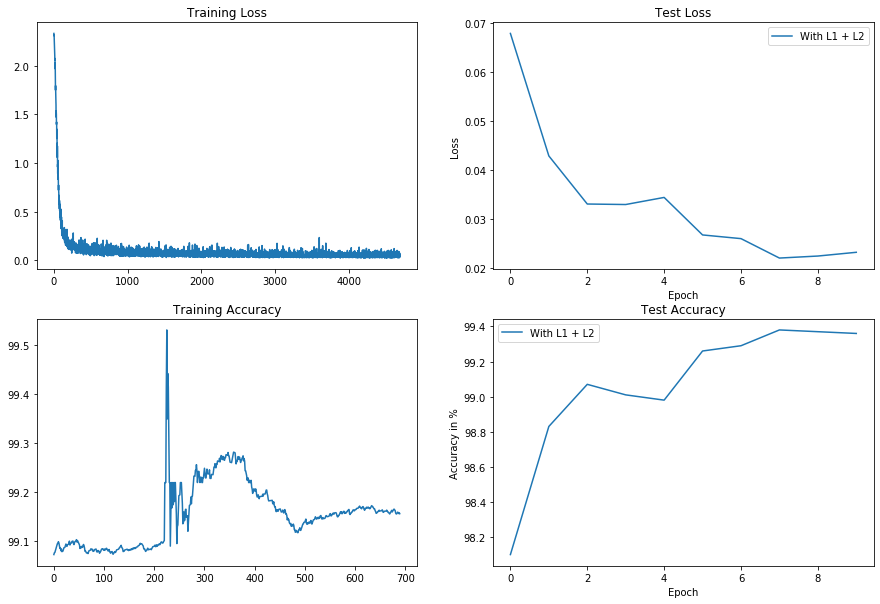

In [9]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses, label=label_name)
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend(loc="best")

axs[1, 1].plot(test_acc, label=label_name)
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy in %")
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend(loc="best")

Correct label tensor([8, 8, 2, 5, 9, 4, 6, 9, 8, 4, 1, 6, 2, 8, 3, 8, 4, 4, 5, 5, 0, 8, 0, 7,
        6], device='cuda:0')
Predicted class tensor([5, 2, 3, 6, 5, 9, 1, 4, 6, 9, 2, 4, 7, 9, 5, 7, 9, 7, 0, 3, 2, 0, 5, 2,
        0], device='cuda:0')


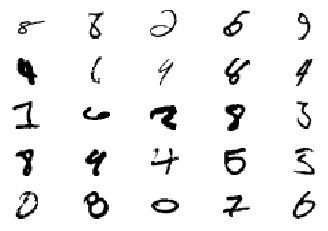

In [10]:
figure = plt.figure()
num_of_images = 25
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(image_wrong[index].cpu().numpy().squeeze(), cmap='gray_r')

print("Correct label",label_wrong[1:num_of_images + 1])
print("Predicted class", pred_wrong[1:num_of_images + 1])

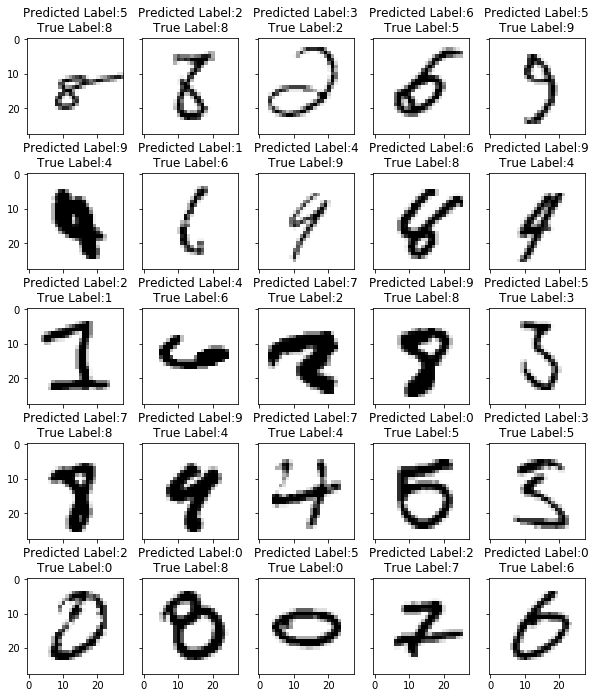

In [11]:
i = 1
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10,12))
for row in range(nrows):
  for col in range(ncols):
    ax[row, col].imshow(image_wrong[i].cpu().numpy().squeeze(), cmap='gray_r')
    ax[row, col].set_title("Predicted Label:{}\nTrue Label:{}".format(pred_wrong[i], label_wrong[i]))
    i += 1
